# Solving the Traveling Salesman  Problem using Local Search

Points: 10

## The [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

* __Goal:__ Find the shortest tour visiting each of $n$ cities exactly once and returning back to the starting city. Given are pairwise distances between cities, where $d_{i,j}$ is the distance from city $i$ to city $j$.

* __State space:__ Each state represents a tour. The cities are numbered and a tour can be expressed as vector  $\pi$ with the order in which the cities are visited (a [permutation](https://en.wikipedia.org/wiki/Permutation)). That is, $\pi(1)$ is the index of the first city to visit, $\pi(2)$ the index of the second, and so on.

* __Objective function:__ Minimize the tour length. The optimization problem is to find the optimal tour $\pi^*$ through the $n$ cities and returning to the starting city:

  > minimize: $\mathrm{tourlength}(\pi) = d_{\pi(n),\pi(1)} + \sum_{i = 1}^{n-1} d_{\pi(i),\pi(i+1)}$
  >
  > subject to: $\pi \ \text{is a valid permutation vector}$

* __Local moves:__ Exchange two cities in the order.

## Helper functions

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

# make the results repeatable
np.random.seed(1234)


In [62]:
def random_tour(n):
    """Create a random tour"""

    tour = list(range(n))
    random.shuffle(tour)
    return(tour)

random_tour(10)

[4, 9, 5, 3, 7, 8, 2, 6, 0, 1]

In [63]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def random_tsp(n):
    """
    Create a random (Euclidean) traveling salesman problem. Choose n points randomly in a 1 x 1 unit square and calulates a
    pairwise Euclidean distance matrix.
    """

    pos = pd.DataFrame({
        "x" : np.random.uniform(size = n),
        "y" : np.random.uniform(size = n)
    })

    dist = squareform(pdist(pos))

    return({"pos": pos, "dist": dist})

tsp = random_tsp(10)

print(f"Positions:\n{tsp['pos']}")
print(f"Distance matrix:\n{pd.DataFrame(tsp['dist'])})")

Positions:
      x     y
0  0.19  0.36
1  0.62  0.50
2  0.44  0.68
3  0.79  0.71
4  0.78  0.37
5  0.27  0.56
6  0.28  0.50
7  0.80  0.01
8  0.96  0.77
9  0.88  0.88
Distance matrix:
      0     1     2     3     4     5     6     7     8     9
0  0.00  0.45  0.41  0.69  0.59  0.22  0.17  0.70  0.87  0.86
1  0.45  0.00  0.26  0.27  0.20  0.35  0.35  0.52  0.43  0.46
2  0.41  0.26  0.00  0.35  0.46  0.21  0.24  0.76  0.53  0.48
3  0.69  0.27  0.35  0.00  0.34  0.53  0.55  0.70  0.18  0.19
4  0.59  0.20  0.46  0.34  0.00  0.54  0.52  0.36  0.44  0.52
5  0.22  0.35  0.21  0.53  0.54  0.00  0.06  0.76  0.72  0.68
6  0.17  0.35  0.24  0.55  0.52  0.06  0.00  0.72  0.73  0.71
7  0.70  0.52  0.76  0.70  0.36  0.76  0.72  0.00  0.77  0.87
8  0.87  0.43  0.53  0.18  0.44  0.72  0.73  0.77  0.00  0.14
9  0.86  0.46  0.48  0.19  0.52  0.68  0.71  0.87  0.14  0.00)


In [64]:
def tour_length(tsp, tour):
    """Caclulate the length of a tour, i.e., the objective function."""

    # make sure tour is a Python list (not an array or a numpy.array)
    if not isinstance(tour, list): tour = tour.tolist()

    tl = 0
    dist = tsp["dist"]

    for i in range(len(tour)-1):
        tl += dist[tour[i], tour[i+1]]

    tl += dist[tour[-1], tour[0]]

    return(tl)

tour = random_tour(10)
tour_length(tsp, tour)

np.float64(4.973950039941981)

In [65]:
def show_tsp(tsp, tour=None):
    """Display the traveling salesman problem and a tour."""

    pos = tsp["pos"]

    plt.scatter(pos["x"], pos["y"])

    if tour is not None:
        # make sure tour is a Python list (not an array or numpy array)
        if not isinstance(tour, list):
            tour = tour.tolist()

        print(f"Tour length: {round(tour_length(tsp, tour), 2)}")

        pos_ = pos.reindex(tour)
        pos_ = pd.concat([pos_, pos_.head(1)])  # ✅ fixed append()
        plt.plot(pos_["x"], pos_["y"], 'r-')

    plt.show()


## Use R to find a solution

Load rpy2, make sure the R [TSP package](https://CRAN.R-project.org/package=TSP) is installed and prepare the distance matrix.

In [66]:
%load_ext rpy2.ipython

%R if(!"TSP" %in% rownames(installed.packages())) install.packages("TSP", repos="http://cran.us.r-project.org")
%R if(!"microbenchmark" %in% rownames(installed.packages())) install.packages("microbenchmark", repos="http://cran.us.r-project.org")

d = tsp["dist"]

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Solve the TSP using [`solve_TSP`](https://www.rdocumentation.org/packages/TSP/versions/1.1-10/topics/solve_TSP) with the default heuristic. Note that 2-opt is steepest ascend hill climbing with exchanging two cities. `rep=100` means 100 random restarts.

In [67]:
%%R -i d -o tour

library("TSP")

tsp <- TSP(d)
print(tsp)

tour <- solve_TSP(tsp, rep = 100)
print(tour)

# R starts index with 1, but Python starts at 0
tour <- tour - 1L

object of class ‘TSP’ 
10 cities (distance ‘unknown’) 
object of class ‘TOUR’ 
result of method ‘arbitrary_insertion+two_opt_rep_100’ for 10 cities
tour length: 2.763574 


Tour length: 2.76


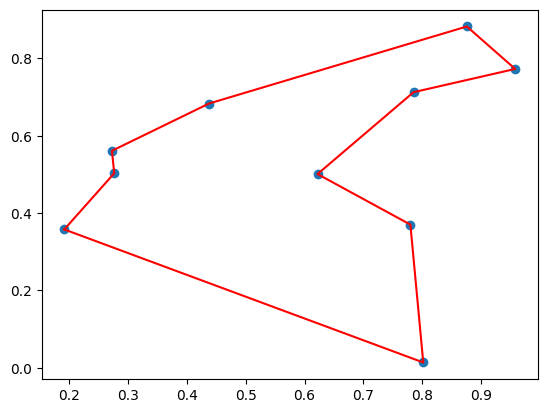

In [68]:
show_tsp(tsp, tour)

How long does it take to solve the problem 100 times?

In [69]:
%%R -i d

library("microbenchmark")

microbenchmark(tsp <- TSP(d))

Unit: microseconds
          expr     min      lq    mean  median       uq      max neval
 tsp <- TSP(d) 361.424 391.791 439.717 411.107 437.1045 1087.627   100


## Steepest-ascend Hill Climbing Search [3 Points]

Calculate the objective function for all local moves (move each queen within its column) and always choose the best among all local moves.

Initial tour length: 8.4466
Iteration 1: improved length = 6.8927
Iteration 2: improved length = 5.9602
Iteration 3: improved length = 5.1996
Iteration 4: improved length = 4.7415
Iteration 5: improved length = 4.3202
Iteration 6: improved length = 4.1930
Iteration 7: improved length = 4.1214
Iteration 8: improved length = 4.0774

 Hill Climbing finished!
Total iterations: 8
Final tour length: 4.0774
Tour length: 4.08


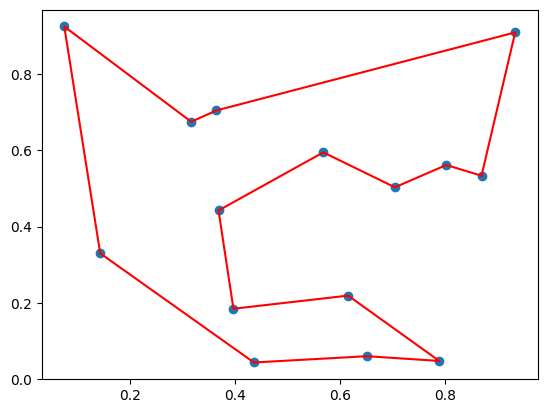

In [70]:
def steepest_ascent_hill_climb(tsp, init_tour):
    current_tour = init_tour.copy()
    current_length = tour_length(tsp, current_tour)
    n = len(current_tour)
    improved = True
    iteration = 0

    print(f"Initial tour length: {current_length:.4f}")

    while improved:
        improved = False
        best_neighbor = current_tour
        best_length = current_length

        # Generate all 2-swap neighbors
        for i in range(n - 1):
            for j in range(i + 1, n):
                neighbor = current_tour.copy()
                neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
                neighbor_length = tour_length(tsp, neighbor)

                # Check if this neighbor is better
                if neighbor_length < best_length:
                    best_neighbor = neighbor
                    best_length = neighbor_length
                    improved = True

        # Update if improvement found
        if improved:
            current_tour = best_neighbor
            current_length = best_length
            iteration += 1
            print(f"Iteration {iteration}: improved length = {current_length:.4f}")

    print("\n Hill Climbing finished!")
    print(f"Total iterations: {iteration}")
    print(f"Final tour length: {current_length:.4f}")

    # Show the final tour visually
    show_tsp(tsp, current_tour)

    return current_tour, current_length


tsp = random_tsp(15)
init_tour = random_tour(15)
best_tour, best_length = steepest_ascent_hill_climb(tsp, init_tour)


## Steepest-ascend Hill Climbing Search with Random Restarts [1 Point]

Steepest-ascend with random restarts.

 Running Steepest-Ascent Hill Climbing with 5 random restarts...

Initial tour length: 8.7655
Iteration 1: improved length = 6.8186
Iteration 2: improved length = 5.9370
Iteration 3: improved length = 5.6133
Iteration 4: improved length = 5.3006
Iteration 5: improved length = 5.0979
Iteration 6: improved length = 4.7774
Iteration 7: improved length = 4.7218
Iteration 8: improved length = 4.6446
Iteration 9: improved length = 4.5911
Iteration 10: improved length = 4.5807
Iteration 11: improved length = 4.4330

 Hill Climbing finished!
Total iterations: 11
Final tour length: 4.4330
Tour length: 4.43


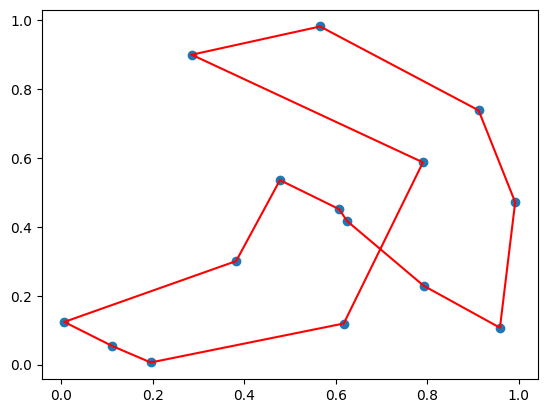

Restart 1: best length = 4.4330
Initial tour length: 7.2845
Iteration 1: improved length = 6.2718
Iteration 2: improved length = 5.6616
Iteration 3: improved length = 5.2457
Iteration 4: improved length = 4.9773
Iteration 5: improved length = 4.7055
Iteration 6: improved length = 4.6219
Iteration 7: improved length = 4.5480

 Hill Climbing finished!
Total iterations: 7
Final tour length: 4.5480
Tour length: 4.55


Restart 2: best length = 4.5480
Initial tour length: 8.5974
Iteration 1: improved length = 7.0407
Iteration 2: improved length = 5.6398
Iteration 3: improved length = 4.8965
Iteration 4: improved length = 4.5429
Iteration 5: improved length = 4.4091
Iteration 6: improved length = 4.2524
Iteration 7: improved length = 4.1387
Iteration 8: improved length = 4.0616

 Hill Climbing finished!
Total iterations: 8
Final tour length: 4.0616
Tour length: 4.06


Restart 3: best length = 4.0616
Initial tour length: 8.5308
Iteration 1: improved length = 6.9941
Iteration 2: improved length = 5.7155
Iteration 3: improved length = 5.0365
Iteration 4: improved length = 4.7139
Iteration 5: improved length = 4.5320
Iteration 6: improved length = 4.4244
Iteration 7: improved length = 4.3351
Iteration 8: improved length = 4.2514

 Hill Climbing finished!
Total iterations: 8
Final tour length: 4.2514
Tour length: 4.25


Restart 4: best length = 4.2514
Initial tour length: 7.8438
Iteration 1: improved length = 5.7259
Iteration 2: improved length = 5.3328
Iteration 3: improved length = 5.0100
Iteration 4: improved length = 4.7532
Iteration 5: improved length = 4.5491
Iteration 6: improved length = 4.3798
Iteration 7: improved length = 4.2961
Iteration 8: improved length = 4.2344
Iteration 9: improved length = 4.2214

 Hill Climbing finished!
Total iterations: 9
Final tour length: 4.2214
Tour length: 4.22


Restart 5: best length = 4.2214

 Random Restart Hill Climbing finished!
Best overall tour length: 4.0616
Tour length: 4.06


In [71]:
# Code goes here
def steepest_ascent_hill_climb_random_restart(tsp, restarts=100):
    best_overall_tour = None
    best_overall_length = float('inf')

    print(f" Running Steepest-Ascent Hill Climbing with {restarts} random restarts...\n")

    for r in range(1, restarts + 1):
        # Random starting tour
        init_tour = random_tour(len(tsp["pos"]))
        best_tour, best_length = steepest_ascent_hill_climb(tsp, init_tour)

        print(f"Restart {r}: best length = {best_length:.4f}")

        # Update global best
        if best_length < best_overall_length:
            best_overall_tour = best_tour
            best_overall_length = best_length

    print("\n Random Restart Hill Climbing finished!")
    print(f"Best overall tour length: {best_overall_length:.4f}")

    show_tsp(tsp, best_overall_tour)

    return best_overall_tour, best_overall_length


tsp = random_tsp(15)
best_tour, best_length = steepest_ascent_hill_climb_random_restart(tsp, restarts=5)


## Stochastic Hill Climbing [1 Points]

Chooses randomly from among all uphill moves.

Stochastic Hill Climbing finished after 13 iterations
Final tour length: 4.5181
Tour length: 4.52


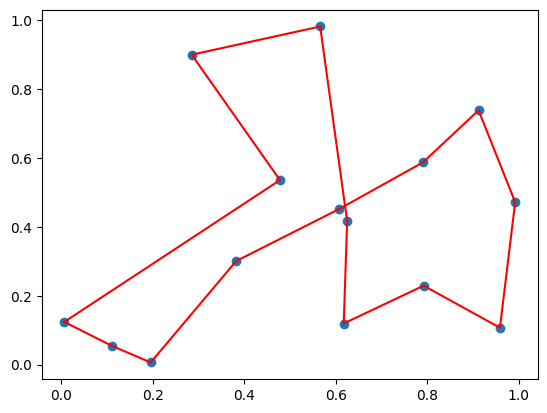

In [72]:


def stochastic_hill_climbing(tsp, init_tour, max_iterations=1000):
    current_tour = init_tour.copy()
    current_length = tour_length(tsp, current_tour)
    n = len(current_tour)
    iteration = 0

    for _ in range(max_iterations):
        improved_neighbors = []

        # Generate all 2-swap neighbors and keep only improving ones
        for i in range(n - 1):
            for j in range(i + 1, n):
                neighbor = current_tour.copy()
                neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
                neighbor_length = tour_length(tsp, neighbor)

                if neighbor_length < current_length:
                    improved_neighbors.append((neighbor, neighbor_length))

        # If no improving neighbors → stop
        if not improved_neighbors:
            break

        # Choose one random better move (stochastic)
        next_tour, next_length = random.choice(improved_neighbors)
        current_tour = next_tour
        current_length = next_length
        iteration += 1

    print(f"Stochastic Hill Climbing finished after {iteration} iterations")
    print(f"Final tour length: {current_length:.4f}")

    return current_tour, current_length


init_tour = list(range(len(tsp["dist"])))  # starting tour
best_tour, best_length = stochastic_hill_climbing(tsp, init_tour)

show_tsp(tsp, best_tour)


## First-choice Hill Climbing [1 Point]

First-choice hill climbing is a type of stochastic hill climbing that generates one random local neighbor at a time and accept it if it has a better objective function value than the current state.

In [73]:
# Code goes here
def first_choice_hill_climbing(tsp, init_tour, max_iterations=10000):
    current_tour = init_tour.copy()
    current_length = tour_length(tsp, current_tour)
    n = len(current_tour)
    iteration = 0

    for _ in range(max_iterations):
        # Randomly choose two cities to swap
        i, j = random.sample(range(n), 2)
        neighbor = current_tour.copy()
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]

        neighbor_length = tour_length(tsp, neighbor)

        # Accept the neighbor if it's better
        if neighbor_length < current_length:
            current_tour = neighbor
            current_length = neighbor_length
            iteration += 1
            print(f"Iteration {iteration}: improved length = {current_length:.4f}")

    print(f"\nFirst-Choice Hill Climbing finished after {iteration} improvements")
    print(f"Final tour length: {current_length:.4f}")
    return current_tour, current_length


init_tour = list(range(len(tsp["dist"])))  # starting tour
best_tour, best_length = first_choice_hill_climbing(tsp, init_tour)

show_tsp(tsp, best_tour)


Iteration 1: improved length = 7.3781
Iteration 2: improved length = 7.2014
Iteration 3: improved length = 6.8564
Iteration 4: improved length = 6.2211
Iteration 5: improved length = 6.0114
Iteration 6: improved length = 5.8363
Iteration 7: improved length = 5.7082
Iteration 8: improved length = 5.4111
Iteration 9: improved length = 5.3074
Iteration 10: improved length = 5.2658
Iteration 11: improved length = 5.1544
Iteration 12: improved length = 4.9549
Iteration 13: improved length = 4.9389
Iteration 14: improved length = 4.8642
Iteration 15: improved length = 4.7075
Iteration 16: improved length = 4.5937
Iteration 17: improved length = 4.5101
Iteration 18: improved length = 4.4962
Iteration 19: improved length = 4.4410
Iteration 20: improved length = 4.3435
Iteration 21: improved length = 4.2152
Iteration 22: improved length = 4.1315
Iteration 23: improved length = 4.0616

First-Choice Hill Climbing finished after 23 improvements
Final tour length: 4.0616
Tour length: 4.06


## Simulated Annealing [2 Points]

Simulated Annealing finished after 2757 iterations
Best tour length: 4.2293
Tour length: 4.23


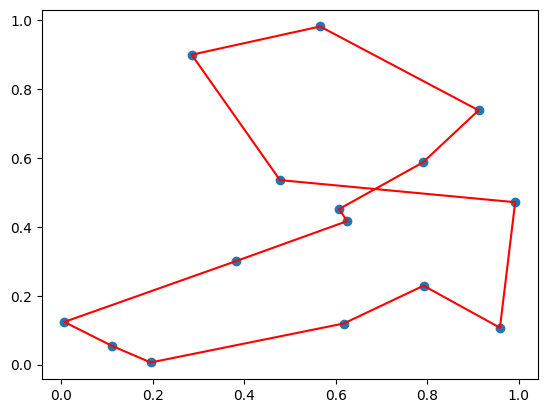

In [74]:
def simulated_annealing(tsp, init_tour, initial_temp=1000, cooling_rate=0.995, min_temp=1e-3, max_iterations=10000):
    """
    Simulated Annealing for the Traveling Salesman Problem (TSP).
    Chooses occasionally worse moves early, fewer as it cools.
    """
    current_tour = init_tour.copy()
    current_length = tour_length(tsp, current_tour)
    best_tour = current_tour.copy()
    best_length = current_length
    temperature = initial_temp
    iteration = 0

    while temperature > min_temp and iteration < max_iterations:
        # Create a random neighbor (2-swap)
        i, j = random.sample(range(len(current_tour)), 2)
        neighbor = current_tour.copy()
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        neighbor_length = tour_length(tsp, neighbor)

        # Calculate difference
        delta = neighbor_length - current_length

        # Accept move (always if better, sometimes if worse)
        if delta < 0 or random.random() < math.exp(-delta / temperature):
            current_tour = neighbor
            current_length = neighbor_length

            # Update best tour if needed
            if current_length < best_length:
                best_tour = current_tour.copy()
                best_length = current_length

        # Cool down
        temperature *= cooling_rate
        iteration += 1

    print(f"Simulated Annealing finished after {iteration} iterations")
    print(f"Best tour length: {best_length:.4f}")

    return best_tour, best_length


init_tour = list(range(len(tsp["dist"])))  # starting tour
best_tour, best_length = simulated_annealing(tsp, init_tour)

show_tsp(tsp, best_tour)


## Compare Performance [2 Points]

Use runtime, scalability (number of cities), and best objective function value to compare the algorithms on boards of different sizes.  

For timing you can use the `time` package.

In [79]:
import time

t0 = time.time()
print("Do something")
t1 = time.time()

print(f"This took: {(t1-t0) * 1e3} milliseconds")

Do something
This took: 0.1475811004638672 milliseconds



=== Comparing algorithms on TSP with 5 cities ===
Initial tour length: 2.9976
Iteration 1: improved length = 2.0628

 Hill Climbing finished!
Total iterations: 1
Final tour length: 2.0628
Tour length: 2.06


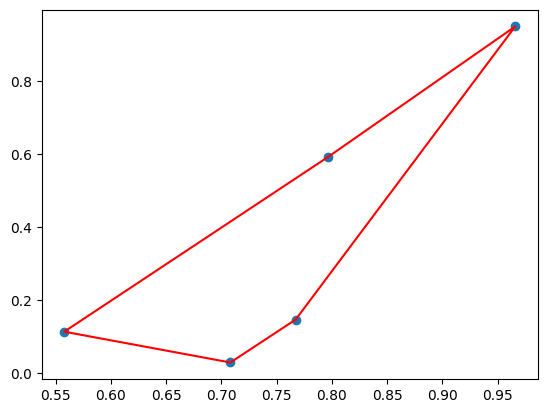

 Steepest-Ascent: length=2.0628, time=0.3566s


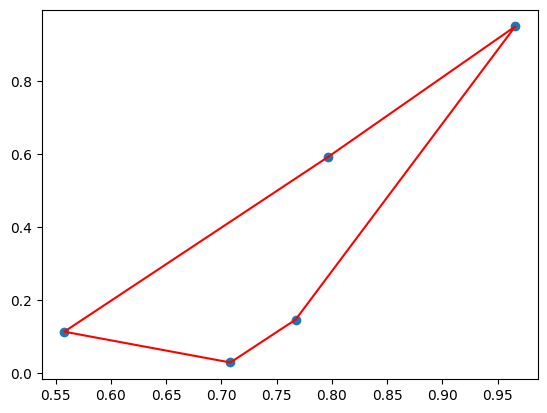

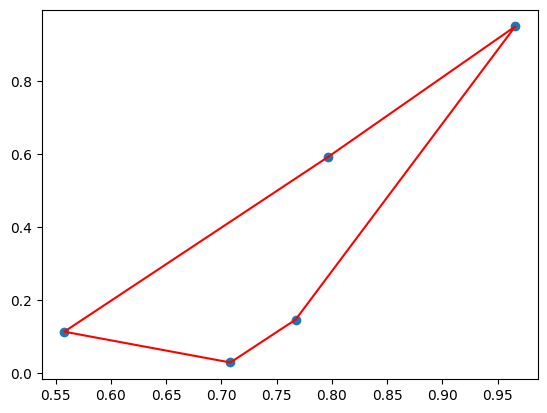

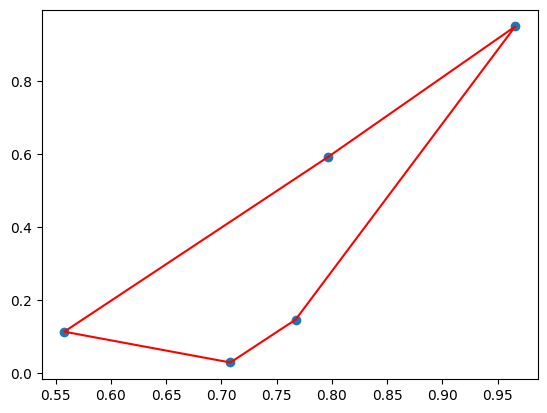

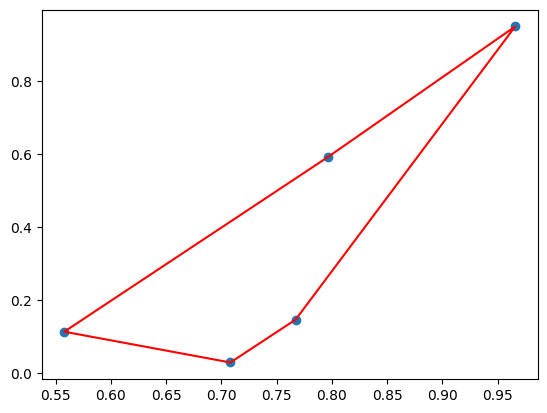

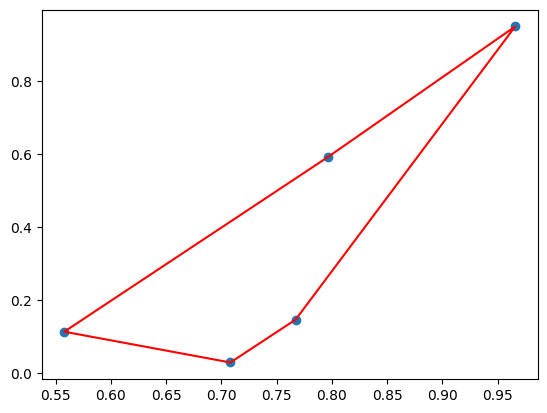

  Random-Restart (5) best length: 2.0628
 Random-Restart:  length=2.0628, time=1.1358s
Stochastic Hill Climbing finished after 1 iterations
Final tour length: 2.0628
 Stochastic:      length=2.0628, time=0.0001s
Iteration 1: improved length = 2.9501
Iteration 2: improved length = 2.0775
Iteration 3: improved length = 2.0628

First-Choice Hill Climbing finished after 3 improvements
Final tour length: 2.0628
 First-Choice:    length=2.0628, time=0.0421s
Simulated Annealing finished after 2757 iterations
Best tour length: 2.0628
 SimulatedAnneal: length=2.0628, time=0.0145s

=== Comparing algorithms on TSP with 10 cities ===
Initial tour length: 4.4218
Iteration 1: improved length = 3.9013
Iteration 2: improved length = 3.7362
Iteration 3: improved length = 3.0628
Iteration 4: improved length = 2.9232
Iteration 5: improved length = 2.8586

 Hill Climbing finished!
Total iterations: 5
Final tour length: 2.8586
Tour length: 2.86


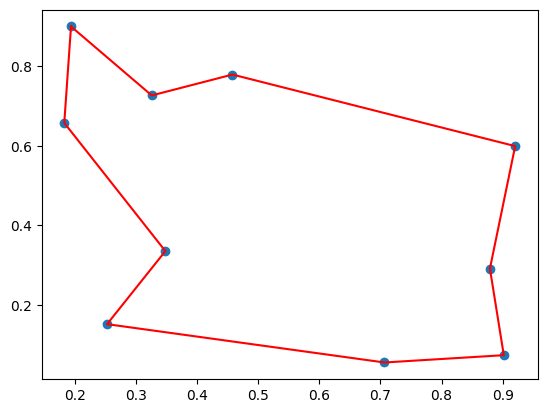

 Steepest-Ascent: length=2.8586, time=0.1324s


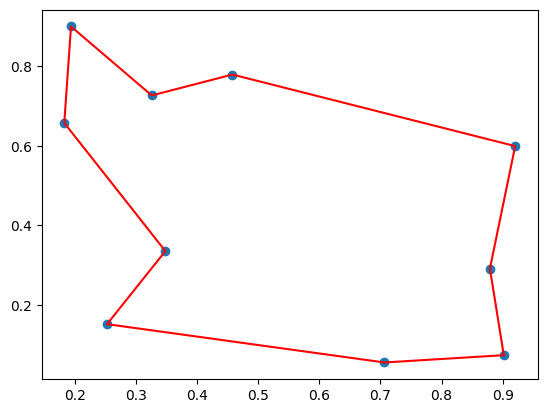

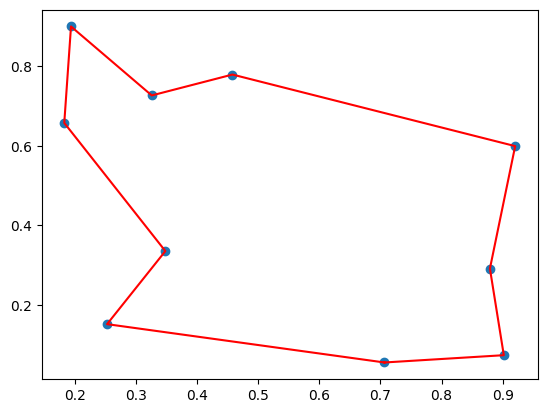

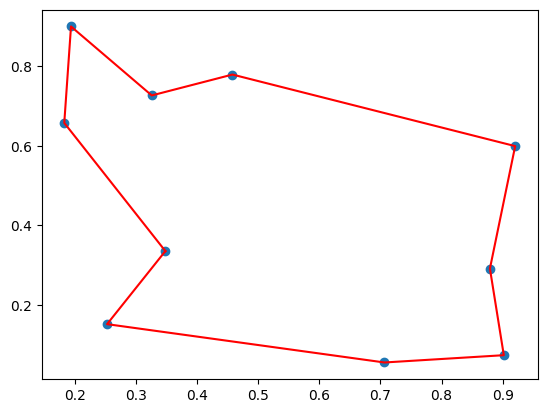

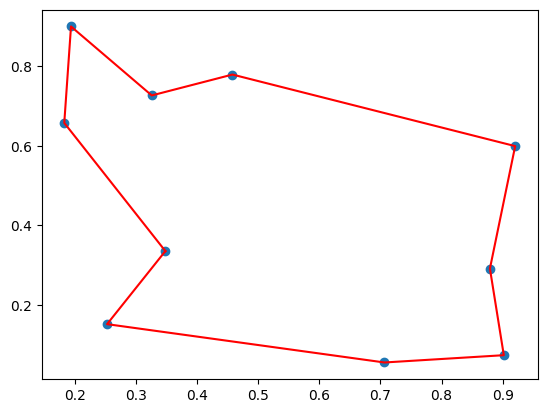

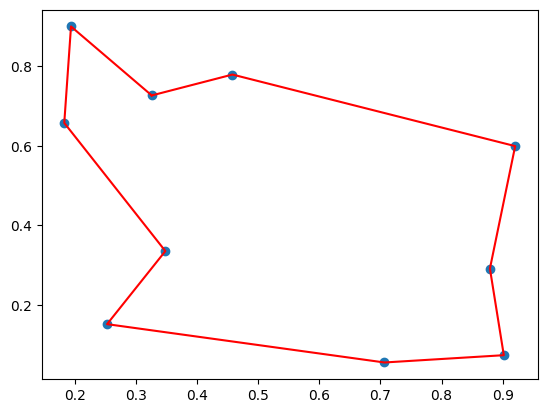

  Random-Restart (5) best length: 2.8586
 Random-Restart:  length=2.8586, time=0.5881s
Stochastic Hill Climbing finished after 5 iterations
Final tour length: 2.8586
 Stochastic:      length=2.8586, time=0.0009s
Iteration 1: improved length = 4.3926
Iteration 2: improved length = 4.3556
Iteration 3: improved length = 4.2485
Iteration 4: improved length = 4.0601
Iteration 5: improved length = 3.4181
Iteration 6: improved length = 3.1548
Iteration 7: improved length = 3.0430
Iteration 8: improved length = 2.8586

First-Choice Hill Climbing finished after 8 improvements
Final tour length: 2.8586
 First-Choice:    length=2.8586, time=0.0583s
Simulated Annealing finished after 2757 iterations
Best tour length: 2.8586
 SimulatedAnneal: length=2.8586, time=0.0151s

=== Comparing algorithms on TSP with 15 cities ===
Initial tour length: 8.4952
Iteration 1: improved length = 6.5729
Iteration 2: improved length = 5.5709
Iteration 3: improved length = 5.0686
Iteration 4: improved length = 4.9994


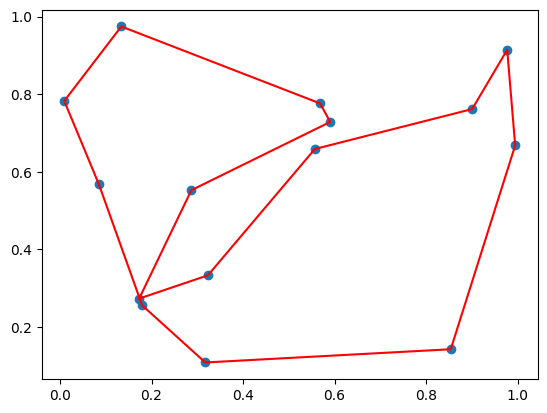

 Steepest-Ascent: length=4.5880, time=0.1069s


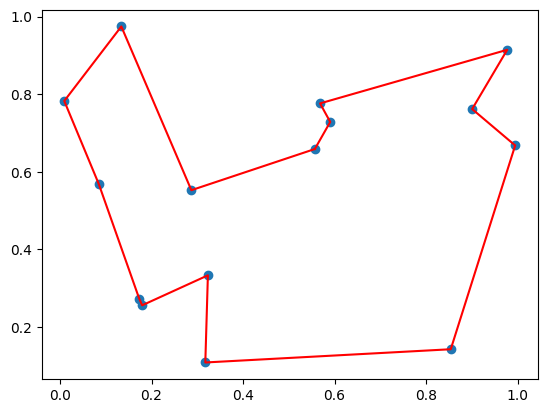

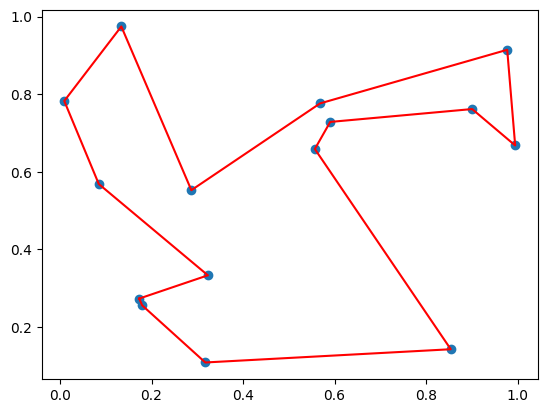

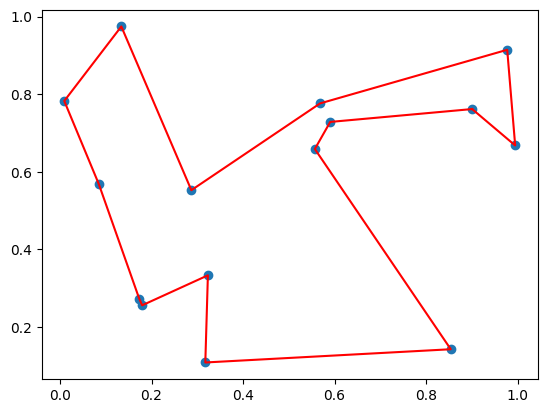

  Random-Restart (5) best length: 3.7292
 Random-Restart:  length=3.7292, time=0.6275s
Stochastic Hill Climbing finished after 11 iterations
Final tour length: 4.4792
 Stochastic:      length=4.4792, time=0.0057s
Iteration 1: improved length = 8.2353
Iteration 2: improved length = 7.8986
Iteration 3: improved length = 7.1115
Iteration 4: improved length = 7.0324
Iteration 5: improved length = 6.0318
Iteration 6: improved length = 5.5779
Iteration 7: improved length = 5.5591
Iteration 8: improved length = 5.5578
Iteration 9: improved length = 5.4748
Iteration 10: improved length = 5.4329
Iteration 11: improved length = 5.2437
Iteration 12: improved length = 5.1193
Iteration 13: improved length = 5.1055
Iteration 14: improved length = 4.7317
Iteration 15: improved length = 4.5841
Iteration 16: improved length = 4.3782
Iteration 17: improved length = 4.3318
Iteration 18: improved length = 4.3141
Iteration 19: improved length = 4.0984
Iteration 20: improved length = 4.0333
Iteration 21: im

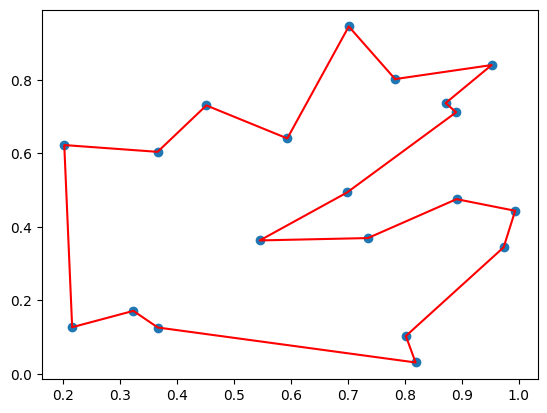

 Steepest-Ascent: length=3.8964, time=0.1325s


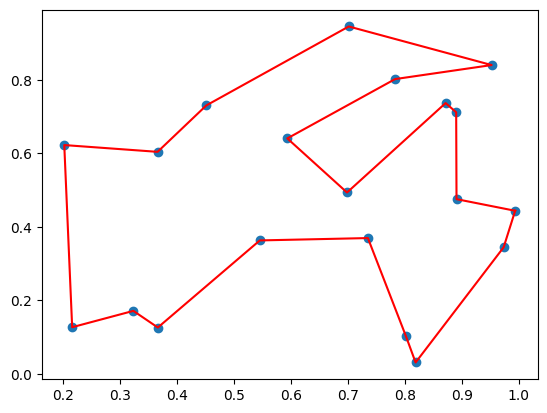

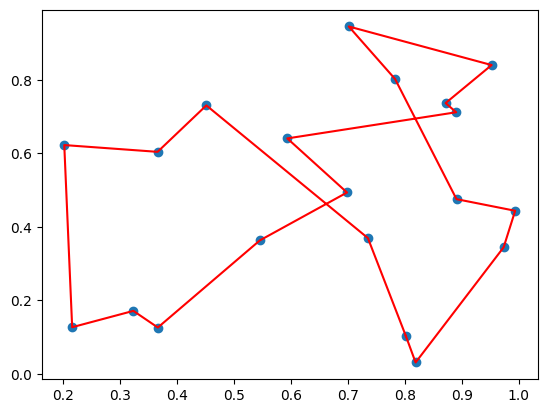

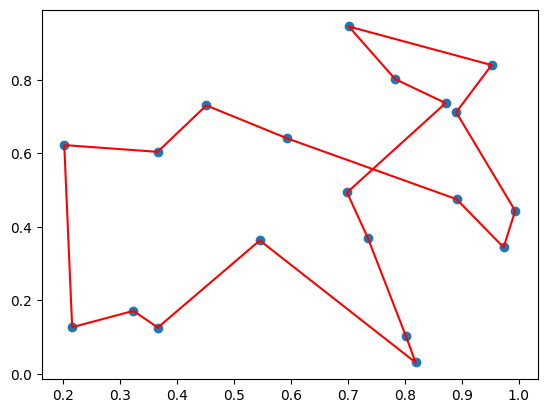

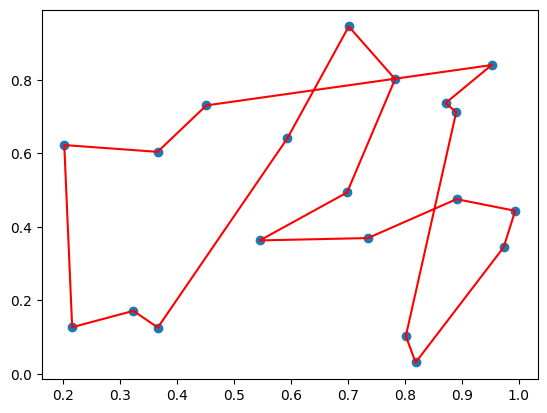

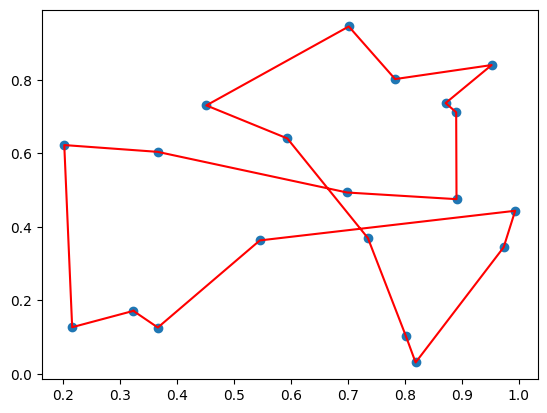

  Random-Restart (5) best length: 4.1580
 Random-Restart:  length=4.1580, time=0.8772s
Stochastic Hill Climbing finished after 39 iterations
Final tour length: 3.9694
 Stochastic:      length=3.9694, time=0.0458s
Iteration 1: improved length = 8.3984
Iteration 2: improved length = 8.3979
Iteration 3: improved length = 8.2352
Iteration 4: improved length = 7.6749
Iteration 5: improved length = 7.6723
Iteration 6: improved length = 6.9657
Iteration 7: improved length = 6.9069
Iteration 8: improved length = 6.8512
Iteration 9: improved length = 6.6131
Iteration 10: improved length = 6.2483
Iteration 11: improved length = 6.2444
Iteration 12: improved length = 6.2163
Iteration 13: improved length = 6.2024
Iteration 14: improved length = 5.9445
Iteration 15: improved length = 5.7006
Iteration 16: improved length = 5.6144
Iteration 17: improved length = 5.4286
Iteration 18: improved length = 5.3911
Iteration 19: improved length = 5.2951
Iteration 20: improved length = 5.1863
Iteration 21: im

Cities  Steepest_Length  Steepest_Time  RandomRestart_Length  \
0       5             2.06           0.36                  2.06   
1      10             2.86           0.13                  2.86   
2      15             4.59           0.11                  3.73   
3      20             3.90           0.13                  4.16   

   RandomRestart_Time  Stochastic_Length  Stochastic_Time  FirstChoice_Length  \
0                1.14               2.06         8.57e-05                2.06   
1                0.59               2.86         8.62e-04                2.86   
2                0.63               4.48         5.70e-03                3.73   
3                0.88               3.97         4.58e-02                4.27   

   FirstChoice_Time  SimAnneal_Length  SimAnneal_Time  
0              0.04              2.06            0.01  
1              0.06              2.86            0.02  
2              0.07              4.16            0.02  
3              0.08              4.29            0.02

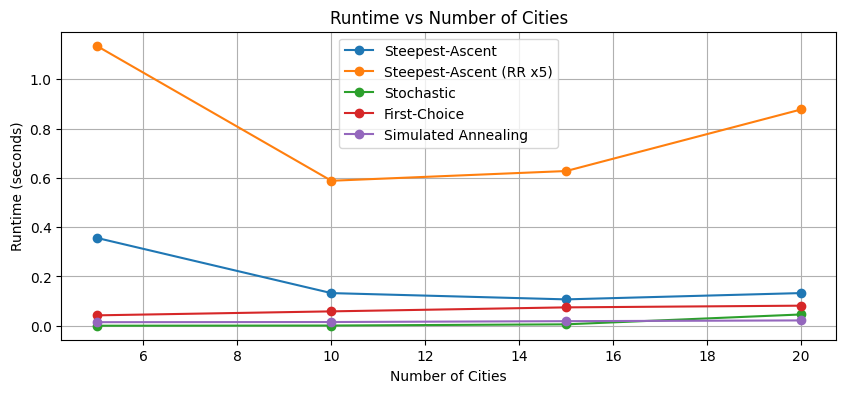

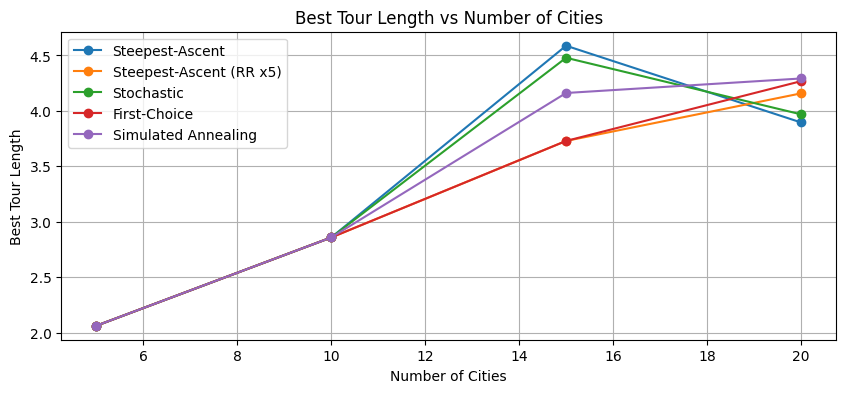

In [82]:
# Code and results go here


city_sizes = [5, 10, 15, 20]

# Number of restarts for the random-restart variant
RR_RESTARTS = 5

# Helper wrapper: Steepest-ascent with random restarts (quiet inside)
def steepest_ascent_hill_climb_random_restart(tsp, restarts=5):
    best_overall_tour = None
    best_overall_length = float('inf')
    # suppress prints from the inner steepest_ascent_hill_climb
    for r in range(restarts):
        init_tour = random_tour(len(tsp["dist"]))
        f = io.StringIO()
        with contextlib.redirect_stdout(f):
            tour, length = steepest_ascent_hill_climb(tsp, init_tour)
        if length < best_overall_length:
            best_overall_length = length
            best_overall_tour = tour
    # print summary for this wrapper
    print(f"  Random-Restart ({restarts}) best length: {best_overall_length:.4f}")
    return best_overall_tour, best_overall_length

results = []

for n in city_sizes:
    print(f"\n=== Comparing algorithms on TSP with {n} cities ===")
    pos = pd.DataFrame({"x": np.random.rand(n), "y": np.random.rand(n)})
    dist = np.sqrt((pos["x"].values[:, None] - pos["x"].values[None, :])**2 +
                   (pos["y"].values[:, None] - pos["y"].values[None, :])**2)
    tsp_n = {"pos": pos, "dist": dist}

    init_tour = list(range(n))

    # Steepest-Ascent
    t0 = time.perf_counter()
    tour_sa, len_sa = steepest_ascent_hill_climb(tsp_n, init_tour)
    t_sa = time.perf_counter() - t0
    print(f" Steepest-Ascent: length={len_sa:.4f}, time={t_sa:.4f}s")

    # Steepest-Ascent w/ Random Restarts
    t0 = time.perf_counter()
    tour_rr, len_rr = steepest_ascent_hill_climb_random_restart(tsp_n, restarts=RR_RESTARTS)
    t_rr = time.perf_counter() - t0
    print(f" Random-Restart:  length={len_rr:.4f}, time={t_rr:.4f}s")

    # Stochastic Hill Climbing
    t0 = time.perf_counter()
    tour_stoch, len_stoch = stochastic_hill_climbing(tsp_n, init_tour)
    t_stoch = time.perf_counter() - t0
    print(f" Stochastic:      length={len_stoch:.4f}, time={t_stoch:.4f}s")

    # First-Choice Hill Climbing
    t0 = time.perf_counter()
    tour_fc, len_fc = first_choice_hill_climbing(tsp_n, init_tour)
    t_fc = time.perf_counter() - t0
    print(f" First-Choice:    length={len_fc:.4f}, time={t_fc:.4f}s")

    # Simulated Annealing
    t0 = time.perf_counter()
    tour_sa2, len_sa2 = simulated_annealing(tsp_n, init_tour)
    t_sa2 = time.perf_counter() - t0
    print(f" SimulatedAnneal: length={len_sa2:.4f}, time={t_sa2:.4f}s")

    results.append({
        "Cities": n,
        "Steepest_Length": len_sa, "Steepest_Time": t_sa,
        "RandomRestart_Length": len_rr, "RandomRestart_Time": t_rr,
        "Stochastic_Length": len_stoch, "Stochastic_Time": t_stoch,
        "FirstChoice_Length": len_fc, "FirstChoice_Time": t_fc,
        "SimAnneal_Length": len_sa2, "SimAnneal_Time": t_sa2
    })

# DataFrame
df_results = pd.DataFrame(results)
print("\n=== Summary Table ===")
display(df_results)

# Plot runtime scalability
plt.figure(figsize=(10,4))
plt.plot(df_results["Cities"], df_results["Steepest_Time"], marker='o', label="Steepest-Ascent")
plt.plot(df_results["Cities"], df_results["RandomRestart_Time"], marker='o', label=f"Steepest-Ascent (RR x{RR_RESTARTS})")
plt.plot(df_results["Cities"], df_results["Stochastic_Time"], marker='o', label="Stochastic")
plt.plot(df_results["Cities"], df_results["FirstChoice_Time"], marker='o', label="First-Choice")
plt.plot(df_results["Cities"], df_results["SimAnneal_Time"], marker='o', label="Simulated Annealing")
plt.xlabel("Number of Cities")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime vs Number of Cities")
plt.legend()
plt.grid(True)
plt.show()

# Plot best objective (tour length) comparison
plt.figure(figsize=(10,4))
plt.plot(df_results["Cities"], df_results["Steepest_Length"], marker='o', label="Steepest-Ascent")
plt.plot(df_results["Cities"], df_results["RandomRestart_Length"], marker='o', label=f"Steepest-Ascent (RR x{RR_RESTARTS})")
plt.plot(df_results["Cities"], df_results["Stochastic_Length"], marker='o', label="Stochastic")
plt.plot(df_results["Cities"], df_results["FirstChoice_Length"], marker='o', label="First-Choice")
plt.plot(df_results["Cities"], df_results["SimAnneal_Length"], marker='o', label="Simulated Annealing")
plt.xlabel("Number of Cities")
plt.ylabel("Best Tour Length")
plt.title("Best Tour Length vs Number of Cities")
plt.legend()
plt.grid(True)
plt.show()


## Bonus: Genetic Algorithm [+1 Point]

In [77]:
# Code goes here